# Bayesian Mixture Model

This notebook illustrate how to build and train a Bayesian Hidden Markov Model with the [beer framework](https://github.com/beer-asr/beer).

In [1]:
# Add "beer" to the PYTHONPATH
import sys
sys.path.insert(0, '../')

import copy

import beer
import numpy as np
import torch

# For plotting.
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, gridplot
from bokeh.models import LinearAxis, Range1d
output_notebook()

# Convenience functions for plotting.
import plotting

%load_ext autoreload
%autoreload 2

Loading BokehJS ...

## Data
Generate data following HMM generative process
#### Probability of initial states
$$
p(s^0 = s_1) = 1 \\
p(s^0 = s_2) = 0 \\
p(s^0 = s_3) = 0
$$

#### Probability of transitions
$$
p(s^t = s_1 \vert s^{t-1} = s_1) = 0.5 \quad p(s^t = s_2 \vert s^{t-1} = s_1) = 0.5 \quad p(s^t = s_3 \vert s^{t-1} = s_1) = 0 \\
p(s^t = s_1 \vert s^{t-1} = s_2) = 0 \quad p(s^t = s_2 \vert s^{t-1} = s_2) = 0.5 \quad p(s^t = s_3 \vert s^{t-1} = s_2) = 0.5 \\
p(s^t = s_1 \vert s^{t-1} = s_3) = 0.5 \quad p(s^t = s_2 \vert s^{t-1} = s_3) = 0 \quad p(s^t = s_3 \vert s^{t-1} = s_3) = 0.5 \\  
$$

#### Emission
$$
p(x^t \vert s^t = s_1) = \mathcal{N}(x^t \vert \mu_1, \Sigma_1) \\
p(x^t \vert s^t = s_2) = \mathcal{N}(x^t \vert \mu_2, \Sigma_2) \\
p(x^t \vert s^t = s_3) = \mathcal{N}(x^t \vert \mu_3, \Sigma_3)
$$


In [2]:
nsamples = 600
ndim = 2
nstates = 3
trans_mat = np.array([[.5, .5, 0], [0, .5, .5], [.5, 0, .5]])

means = [np.array([-1.5, 4]) * 2,np.array([5, 5]) * 2, np.array([1, -2])] * 2
covs = [np.array([[.75, -.5], [-.5, 2.]]), np.array([[2, 1], [1, .75]]), np.array([[1, 0], [0, 1]]) ]
normal_sets = [[means[0], covs[0]], [means[1], covs[1]], [means[2], covs[2]]] 

states = np.zeros(nsamples, dtype=int)
data = np.zeros((nsamples, ndim))
states[0] = 0
data[0] = np.random.multivariate_normal(means[states[0]], covs[states[0]], size=1)

colors = ['blue', 'red', 'green']
fig1 = figure(title='Samples', width=400, height=400)
fig1.circle(data[0, 0], data[0, 1], color=colors[states[0]])


for n in range(1, nsamples):
    states[n] = np.random.choice(np.arange(nstates), p=trans_mat[states[n-1]])
    data[n] = np.random.multivariate_normal(means[states[n]], covs[states[n]], size=1)
    fig1.circle(data[n, 0], data[n, 1], color=colors[states[n]], line_width=1)
    fig1.line(data[n-1:n+1, 0], data[n-1:n+1, 1], color='black', line_width=.5, alpha=.5)

fig2 = figure(title='Emissions',  width=400, height=400)
colors = ['blue', 'red', 'green']
for i, n in enumerate(normal_sets):
    plotting.plot_normal(fig2, n[0], n[1], alpha=.3, color=colors[i])
grid = gridplot([[fig1, fig2]])
show(grid)

## Model Creation

We create several types of HMMs, each of them has the same transition matrix and initial / final state probability, and a specific type of emission density: 
  * one Normal density per state with full covariance matrix
  * one Normal density per state with diagonal covariance matrix
  * one Normal density per state with full covariance matrix shared across states
  * one Normal density per state with diagonal covariance matrix shared across states.

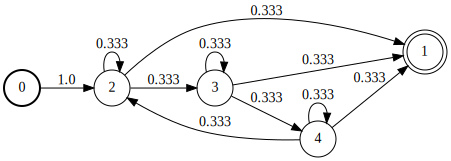

In [3]:
graph = beer.graph.Graph()

# Initial and final state are non-emitting.
s0 = graph.add_state()
s4 = graph.add_state()
graph.start_state = s0
graph.end_state = s4

s1 = graph.add_state(pdf_id=0)
s2 = graph.add_state(pdf_id=1)
s3 = graph.add_state(pdf_id=2)
graph.add_arc(s0, s1)
graph.add_arc(s1, s1)
graph.add_arc(s1, s2)
graph.add_arc(s2, s2)
graph.add_arc(s2, s3)
graph.add_arc(s3, s3)
graph.add_arc(s3, s1)
graph.add_arc(s1, s4)
graph.add_arc(s2, s4)
graph.add_arc(s3, s4)

graph.normalize()
graph

In [4]:
cgraph = graph.compile()
cgraph.final_log_probs

tensor([-1.0986, -1.0986, -1.0986])

In [5]:
# We use the global mean/cov. matrix of the data to initialize the mixture.
data_mean = torch.from_numpy(data.mean(axis=0)).float()
data_var = torch.from_numpy(np.cov(data.T)).float()

init_states = torch.LongTensor([0])
final_states = torch.LongTensor([2])
transitions = torch.from_numpy(trans_mat).float()

# HMM (isotropic cov).
modelset = beer.NormalSet.create(data_mean, data_var, size=len(transitions),
                                prior_strength=1., noise_std=0, 
                                cov_type='isotropic')
hmm_iso = beer.HMM.create(cgraph, modelset)

# HMM (diag cov).
modelset = beer.NormalSet.create(data_mean, data_var, size=len(transitions),
                                prior_strength=1., noise_std=0, 
                                cov_type='diagonal')
hmm_diag = beer.HMM.create(cgraph, modelset)

# HMM (full cov).
modelset = beer.NormalSet.create(data_mean, data_var, size=len(transitions),
                                prior_strength=1., noise_std=0, 
                                cov_type='full')
hmm_full = beer.HMM.create(cgraph, modelset)


models = {
    'hmm_iso': hmm_iso.double(),
    'hmm_diag': hmm_diag.double(), 
    'hmm_full': hmm_full.double()
}

print(hmm_full) 

HMM(
  (modelset): DynamicallyOrderedModelSet(
    (original_modelset): NormalSet(
      (means_precisions): ConjugateBayesianParameter(prior=NormalWishart, posterior=NormalWishart)
    )
  )
  (graph): <CompiledGraph>
)


## Variational Bayes Training 

In [6]:
epochs = 100
lrate = 1.
X = torch.from_numpy(data).double()

optims = {
    model_name: beer.VariationalBayesOptimizer(model.mean_field_factorization(), lrate)
    for model_name, model in models.items()
}

elbos = {
    model_name: [] 
    for model_name in models
}  

for epoch in range(epochs):
    for name, model in models.items():
        optim = optims[name]
        optim.init_step()
        elbo = beer.evidence_lower_bound(model, X, datasize=len(X), viterbi=False)
        elbo.backward()
        elbos[name].append(float(elbo) / len(X)) 
        optim.step()

In [7]:
colors = {
    'hmm_iso': 'green',
    'hmm_diag': 'blue',
    'hmm_full': 'red',    
}
# Plot the ELBO.
fig = figure(title='ELBO', width=400, height=400, x_axis_label='step',
              y_axis_label='ln p(X)')
for model_name, elbo in elbos.items():
    fig.line(range(len(elbo)), elbo, legend=model_name, color=colors[model_name])
fig.legend.location = 'bottom_right'

show(fig)

### Plotting

In [8]:
figs = []
for i, model_name in enumerate(models):
    model = models[model_name]
    fig = figure(title=model_name, width=250, height=250)
    fig.circle(data[:, 0], data[:, 1], alpha=.1)
    plotting.plot_hmm(fig, model, alpha=.3, colors=['blue', 'red', 'green'])
    if i % 3 == 0:
        figs.append([])
    figs[-1].append(fig)
grid = gridplot(figs)
show(grid)

In [9]:
model = models['hmm_full']
best_path = model.decode(X).numpy()
best_path, states

(array([0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1,
        1, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2,
        2, 0, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 2, 0, 0, 0, 1, 1, 2, 0, 1, 1, 2, 0, 0, 1, 1, 1, 2, 2, 0, 1, 2,
        0, 0, 1, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 1, 1, 2, 2, 2, 2, 0, 1, 2,
        2, 0, 0, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 2, 0, 0, 0, 1, 1, 2, 0,
        0, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 0, 1, 1, 2, 0, 0, 0, 0, 1, 1, 2,
        0, 0, 0, 1, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1,
        1, 2, 0, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 1, 2, 2, 0, 0, 1,
        1, 2, 0, 0, 1, 2, 2, 2, 2, 0, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 2, 2, 0,
        1, 2, 0, 1, 1, 1, 2, 2, 0, 1, 2, 2, 2, 2, 2, 0, 1, 1, 1, 2, 2, 2,
        0, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 1, 1, 2, 0, 1, 1, 1, 2, 0, 1, 1,
        1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 

In [10]:
model.modelset

DynamicallyOrderedModelSet(
  (original_modelset): NormalSet(
    (means_precisions): ConjugateBayesianParameter(prior=NormalWishart, posterior=NormalWishart)
  )
)